## 3. Training, prediction with GluonTS

In this notebook, we train a GlueonTS model with the pre-processed data, make prediction for 1 week, and store the prediction in S3 for comparison later.


In [26]:
pip install gluonts

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
my_bucket_name = "s3://[my bucket name]"

In [28]:
file_prefix = ["2019", "2020", "2021", "2022"]
df = pd.DataFrame()
for fp in file_prefix:
    print(f"processing {fp}")
    temp = pd.read_csv(f"{my_bucket_name}/nyc-taxi-trip-data-processed/{fp}_processed.csv", 
                       index_col=0, parse_dates=[1], infer_datetime_format=True)
    temp = temp.drop(columns=['trip_distance', 'total_amount', 'duration'])
    df = pd.concat([df, temp])
    
    


processing 2019
processing 2020
processing 2021
processing 2022


In [29]:
df.head()

,pickup_time,PULocationID,count
977163,2001-01-01 00:00:00,48,1
282756,2001-01-01 00:00:00,151,1
381760,2002-02-02 01:00:00,48,3
785671,2002-02-02 01:00:00,48,1
381761,2002-02-02 01:00:00,79,1


In [30]:
df.tail()


,pickup_time,PULocationID,count
268697,2022-12-01 15:00:00,162,1
268698,2022-12-01 15:00:00,237,1
268699,2022-12-01 16:00:00,141,1
268700,2022-12-01 23:00:00,237,1
339729,2023-04-18 14:00:00,237,1


In [31]:
df.dtypes

pickup_time     datetime64[ns]
PULocationID             int64
count                    int64
dtype: object

In [32]:
df.shape

(3768628, 3)

In [33]:
df = df[df['pickup_time'] >= "2019-01-01 00:00:00"]
df = df[df['pickup_time'] <= "2022-12-31 11:59:59"]

In [34]:
df.shape

(3767303, 3)

In [35]:
df[['pickup_time', 'PULocationID']].duplicated(keep=False).sum()

10324

In [36]:
df = df.groupby(by=['pickup_time', 'PULocationID']).sum()

In [37]:
df = df.reset_index()

In [38]:
df

,pickup_time,PULocationID,count
0,2019-01-01 00:00:00,4,49
1,2019-01-01 00:00:00,7,24
2,2019-01-01 00:00:00,10,2
3,2019-01-01 00:00:00,11,2
4,2019-01-01 00:00:00,12,4
...,...,...,...
3762130,2022-12-01 15:00:00,141,1
3762131,2022-12-01 15:00:00,162,1
3762132,2022-12-01 15:00:00,237,1
3762133,2022-12-01 16:00:00,141,1


In [39]:
df[['pickup_time', 'PULocationID']].duplicated(keep=False).sum()

0

In [40]:
df.shape

(3762135, 3)

In [41]:
df.head()

,pickup_time,PULocationID,count
0,2019-01-01,4,49
1,2019-01-01,7,24
2,2019-01-01,10,2
3,2019-01-01,11,2
4,2019-01-01,12,4


In [42]:
df = df.set_index("pickup_time")
df

,PULocationID,count
pickup_time,,
2019-01-01 00:00:00,4,49
2019-01-01 00:00:00,7,24
2019-01-01 00:00:00,10,2
2019-01-01 00:00:00,11,2
2019-01-01 00:00:00,12,4
...,...,...
2022-12-01 15:00:00,141,1
2022-12-01 15:00:00,162,1
2022-12-01 15:00:00,237,1


In [74]:
pul_sel = df.groupby(by='PULocationID').sum().sort_values(by='count', ascending=False).head(10).index.to_list()

In [75]:
pul_sel

[237, 236, 161, 186, 162, 132, 142, 170, 230, 48]

In [76]:
pul_sel.index(237)

0

In [77]:
pul_sel[0]

237

In [78]:
df_sel = df[df['PULocationID'].isin(pul_sel)]

PULocationID
48     AxesSubplot(0.125,0.2;0.775x0.68)
132    AxesSubplot(0.125,0.2;0.775x0.68)
142    AxesSubplot(0.125,0.2;0.775x0.68)
161    AxesSubplot(0.125,0.2;0.775x0.68)
162    AxesSubplot(0.125,0.2;0.775x0.68)
170    AxesSubplot(0.125,0.2;0.775x0.68)
186    AxesSubplot(0.125,0.2;0.775x0.68)
230    AxesSubplot(0.125,0.2;0.775x0.68)
236    AxesSubplot(0.125,0.2;0.775x0.68)
237    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

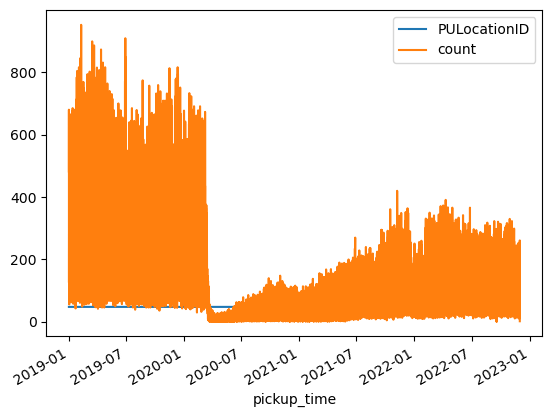

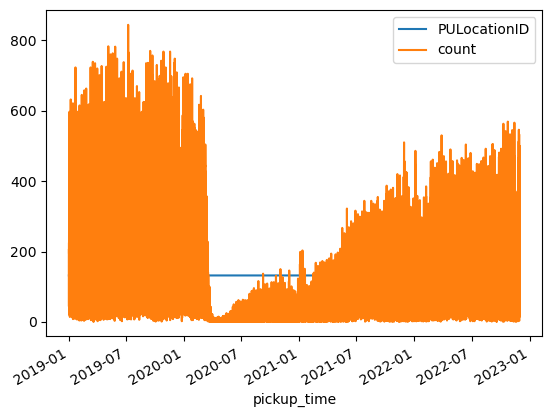

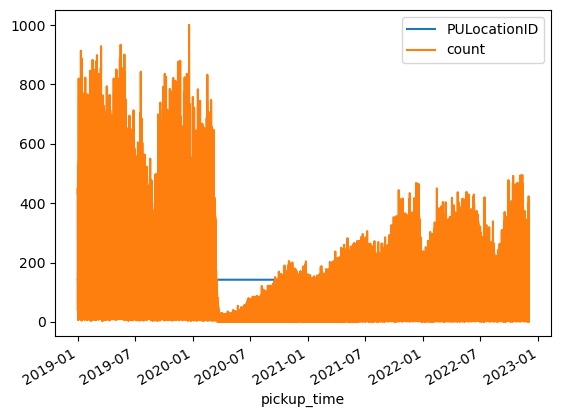

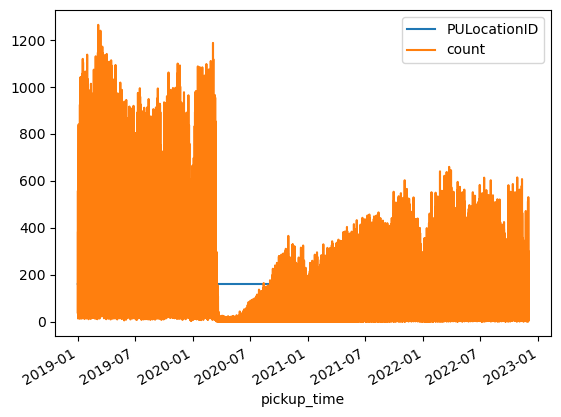

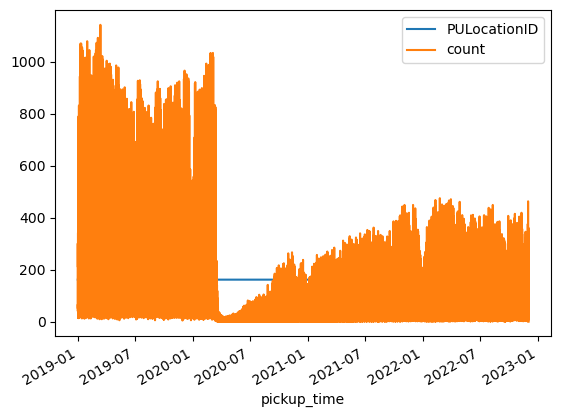

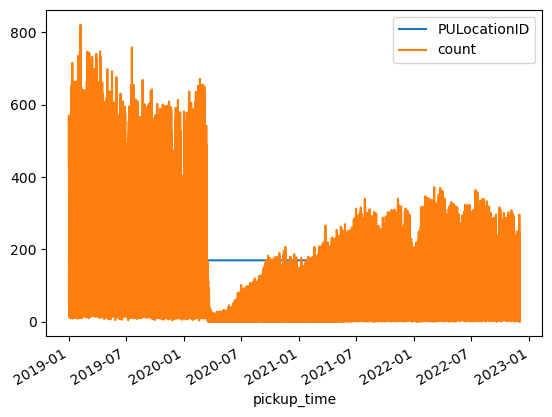

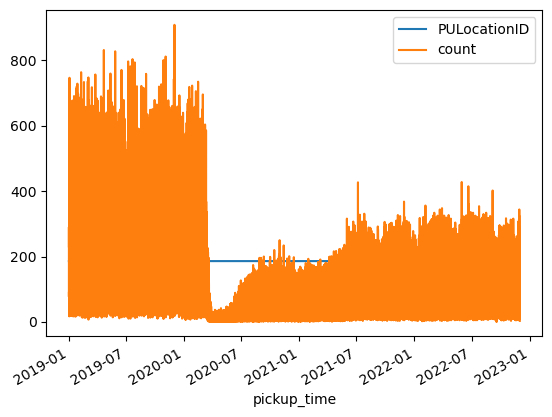

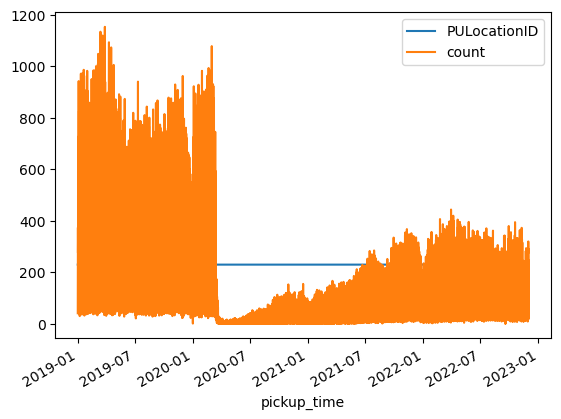

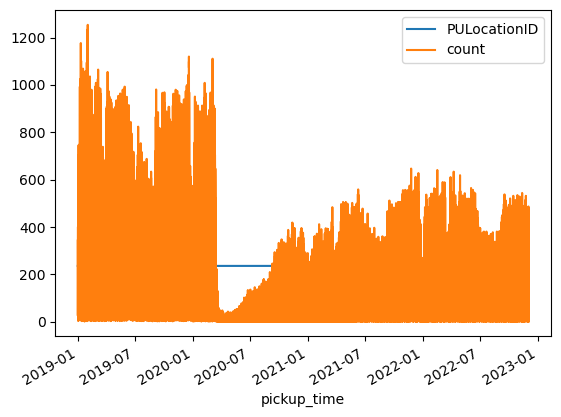

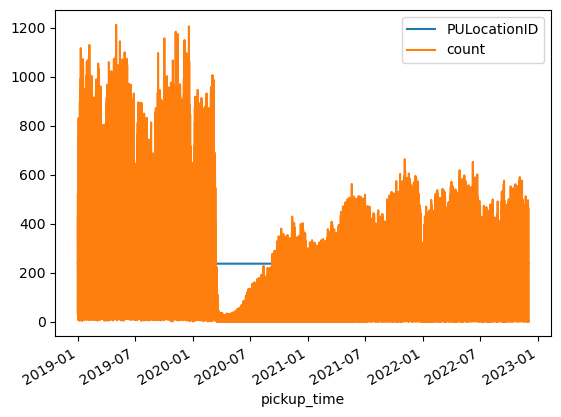

In [79]:
df_sel.groupby("PULocationID").plot()

**There must be a radical change in the data at middle of 2020. We only take data after 2020 November.**

In [49]:
df_sel = df_sel["2020-11-01":]

In [50]:
df_sel.head()

,PULocationID,count
pickup_time,,
2020-11-01,48,132
2020-11-01,132,15
2020-11-01,142,31
2020-11-01,161,18
2020-11-01,162,24


In [51]:
df_sel.to_csv(f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/df_sel.csv")

In [52]:
for item_id, gdf in df_sel.groupby("PULocationID"):
    print(f"item id {item_id}, gdf {gdf}")

item id 48, gdf                      PULocationID  count
pickup_time                             
2020-11-01 00:00:00            48    132
2020-11-01 01:00:00            48    148
2020-11-01 02:00:00            48     29
2020-11-01 03:00:00            48     19
2020-11-01 04:00:00            48     11
...                           ...    ...
2022-11-30 20:00:00            48    197
2022-11-30 21:00:00            48    240
2022-11-30 22:00:00            48    261
2022-11-30 23:00:00            48    191
2022-12-01 00:00:00            48      2

[18227 rows x 2 columns]
item id 132, gdf                      PULocationID  count
pickup_time                             
2020-11-01 00:00:00           132     15
2020-11-01 01:00:00           132     31
2020-11-01 02:00:00           132     13
2020-11-01 04:00:00           132      1
2020-11-01 05:00:00           132     15
...                           ...    ...
2022-11-30 19:00:00           132    436
2022-11-30 20:00:00           132    47

In [53]:
# faster 0.15433716773986816 secs
import time
start = time.time()

max_end = max(df_sel.groupby("PULocationID").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in df_sel.groupby("PULocationID"):
    no = pul_sel.index(item_id)
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")
    dfs_dict[no] = gdf.reindex(new_index)
    dfs_dict[no]['PULocationID'].fillna(item_id, inplace=True)
    dfs_dict[no]['count'].fillna(0, inplace=True)

print(time.time() - start)
#from gluonts.dataset.pandas import PandasDataset
#ds = PandasDataset(dfs_dict, target="target")

0.02974987030029297


In [54]:
'''
# faster 1.032006025314331 secs
import time
start = time.time()

max_end = max(df.groupby("PULocationID").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in df.groupby("PULocationID"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")
    dfs_dict[item_id] = gdf.reindex(new_index)
    dfs_dict[item_id]['PULocationID'].fillna(item_id, inplace=True)
    dfs_dict[item_id]['count'].fillna(0, inplace=True)

print(time.time() - start)
#from gluonts.dataset.pandas import PandasDataset
#ds = PandasDataset(dfs_dict, target="target")
'''

'\n# faster 1.032006025314331 secs\nimport time\nstart = time.time()\n\nmax_end = max(df.groupby("PULocationID").apply(lambda _df: _df.index[-1]))\ndfs_dict = {}\nfor item_id, gdf in df.groupby("PULocationID"):\n    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")\n    dfs_dict[item_id] = gdf.reindex(new_index)\n    dfs_dict[item_id][\'PULocationID\'].fillna(item_id, inplace=True)\n    dfs_dict[item_id][\'count\'].fillna(0, inplace=True)\n\nprint(time.time() - start)\n#from gluonts.dataset.pandas import PandasDataset\n#ds = PandasDataset(dfs_dict, target="target")\n'

In [55]:
dfs_dict

{9:                      PULocationID  count
 2020-11-01 00:00:00          48.0  132.0
 2020-11-01 01:00:00          48.0  148.0
 2020-11-01 02:00:00          48.0   29.0
 2020-11-01 03:00:00          48.0   19.0
 2020-11-01 04:00:00          48.0   11.0
 ...                           ...    ...
 2022-12-01 19:00:00          48.0    0.0
 2022-12-01 20:00:00          48.0    0.0
 2022-12-01 21:00:00          48.0    0.0
 2022-12-01 22:00:00          48.0    0.0
 2022-12-01 23:00:00          48.0    0.0
 
 [18264 rows x 2 columns],
 5:                      PULocationID  count
 2020-11-01 00:00:00         132.0   15.0
 2020-11-01 01:00:00         132.0   31.0
 2020-11-01 02:00:00         132.0   13.0
 2020-11-01 03:00:00         132.0    0.0
 2020-11-01 04:00:00         132.0    1.0
 ...                           ...    ...
 2022-12-01 19:00:00         132.0    0.0
 2022-12-01 20:00:00         132.0    0.0
 2022-12-01 21:00:00         132.0    0.0
 2022-12-01 22:00:00         132.0    0.0

In [56]:
'''
#slower 51.51436710357666 secs
import time
start = time.time()

max_end = df.index.max()
plids = df['PULocationID'].unique()
df_imp = pd.DataFrame()
for plid in plids:
    pl = df[df['PULocationID']==plid]
    pl = pl.reindex(pd.date_range(pl.index[0], end=max_end, freq="1H"))
    pl = pl.reset_index()
    pl.fillna(plid, inplace=True)
    pl.fillna(0, inplace=True)
    df_imp = pd.concat([df_imp, pl], ignore_index=True)

print(time.time() - start)
'''

'\n#slower 51.51436710357666 secs\nimport time\nstart = time.time()\n\nmax_end = df.index.max()\nplids = df[\'PULocationID\'].unique()\ndf_imp = pd.DataFrame()\nfor plid in plids:\n    pl = df[df[\'PULocationID\']==plid]\n    pl = pl.reindex(pd.date_range(pl.index[0], end=max_end, freq="1H"))\n    pl = pl.reset_index()\n    pl.fillna(plid, inplace=True)\n    pl.fillna(0, inplace=True)\n    df_imp = pd.concat([df_imp, pl], ignore_index=True)\n\nprint(time.time() - start)\n'

In [57]:
from gluonts.dataset.pandas import PandasDataset

In [58]:
train_ds = PandasDataset(
    {pulid: puldf.loc[:'2022-10-31 23:00:00'] for pulid, puldf in dfs_dict.items()},
    target = "count",
    freq = "1H"
)
# or testing we feed the entire dataset into make_evaluation_predictions, 
# which automatically splits the last prediction_length entries for us and returns their predictions. 
test_ds = PandasDataset(
    {pulid: puldf.loc[:'2022-11-07 23:00:00'] for pulid, puldf in dfs_dict.items()},
    target = "count",
    freq = "1H"
)

In [59]:
train_ds

PandasDataset(target='count', feat_dynamic_real=None, past_feat_dynamic_real=None, timestamp=None, freq='1H', future_length=0, unchecked=False, assume_sorted=False, dtype=<class 'numpy.float32'>, _data_entries=StarMap(fn=<bound method PandasDataset._pair_to_dataentry of ...>, iterable=dict_items([(9,                      PULocationID  count
2020-11-01 00:00:00          48.0  132.0
2020-11-01 01:00:00          48.0  148.0
2020-11-01 02:00:00          48.0   29.0
2020-11-01 03:00:00          48.0   19.0
2020-11-01 04:00:00          48.0   11.0
...                           ...    ...
2022-10-31 19:00:00          48.0  127.0
2022-10-31 20:00:00          48.0  152.0
2022-10-31 21:00:00          48.0  139.0
2022-10-31 22:00:00          48.0  122.0
2022-10-31 23:00:00          48.0  135.0

[17520 rows x 2 columns]), (5,                      PULocationID  count
2020-11-01 00:00:00         132.0   15.0
2020-11-01 01:00:00         132.0   31.0
2020-11-01 02:00:00         132.0   13.0
2020-11-01

In [60]:
test_ds

PandasDataset(target='count', feat_dynamic_real=None, past_feat_dynamic_real=None, timestamp=None, freq='1H', future_length=0, unchecked=False, assume_sorted=False, dtype=<class 'numpy.float32'>, _data_entries=StarMap(fn=<bound method PandasDataset._pair_to_dataentry of ...>, iterable=dict_items([(9,                      PULocationID  count
2020-11-01 00:00:00          48.0  132.0
2020-11-01 01:00:00          48.0  148.0
2020-11-01 02:00:00          48.0   29.0
2020-11-01 03:00:00          48.0   19.0
2020-11-01 04:00:00          48.0   11.0
...                           ...    ...
2022-11-07 19:00:00          48.0  154.0
2022-11-07 20:00:00          48.0  157.0
2022-11-07 21:00:00          48.0  152.0
2022-11-07 22:00:00          48.0  192.0
2022-11-07 23:00:00          48.0  110.0

[17688 rows x 2 columns]), (5,                      PULocationID  count
2020-11-01 00:00:00         132.0   15.0
2020-11-01 01:00:00         132.0   31.0
2020-11-01 02:00:00         132.0   13.0
2020-11-01

In [61]:
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [62]:
# 1 weeks of prediction
prediction_length = 24 * 7
estimator = DeepAREstimator(
    freq="1H",
    prediction_length=prediction_length,
    trainer=Trainer(epochs=10),
)

In [63]:
predictor = estimator.train(train_ds)
forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor)
forecasts = list(forecast_it)
tests = list(ts_it)
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tests, forecasts, num_series=len(test_ds))

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 34.56it/s]


In [64]:
agg_metrics['MSE']

1052.4276573250986

In [66]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id='9', samples=array([[ 55.0791  ,  45.838665,  39.92731 , ..., 171.326   , 199.22696 ,
         135.51518 ],
        [ 92.838066,  62.822327,  46.76732 , ..., 207.47392 , 150.27786 ,
         177.04916 ],
        [ 68.690285,  38.933064,  25.872911, ..., 161.17578 , 163.23495 ,
         124.5156  ],
        ...,
        [ 87.75903 ,  48.70153 ,  50.656902, ..., 216.65279 , 222.83827 ,
         192.14177 ],
        [ 72.71933 ,  50.490025,  41.407387, ..., 221.20377 , 137.71355 ,
         129.45314 ],
        [ 74.76952 ,  13.009666,  29.87006 , ..., 223.24475 , 185.94003 ,
         134.7455  ]], dtype=float32), start_date=Period('2022-11-01 00:00', 'H')),
 gluonts.model.forecast.SampleForecast(info=None, item_id='5', samples=array([[221.04416 ,  56.028828,  20.819805, ..., 440.50195 , 396.0005  ,
         402.95877 ],
        [187.62292 ,  77.3995  ,  19.209589, ..., 421.50284 , 410.64783 ,
         406.33286 ],
        [147.9418

In [68]:
forecasts[0].item_id

'9'

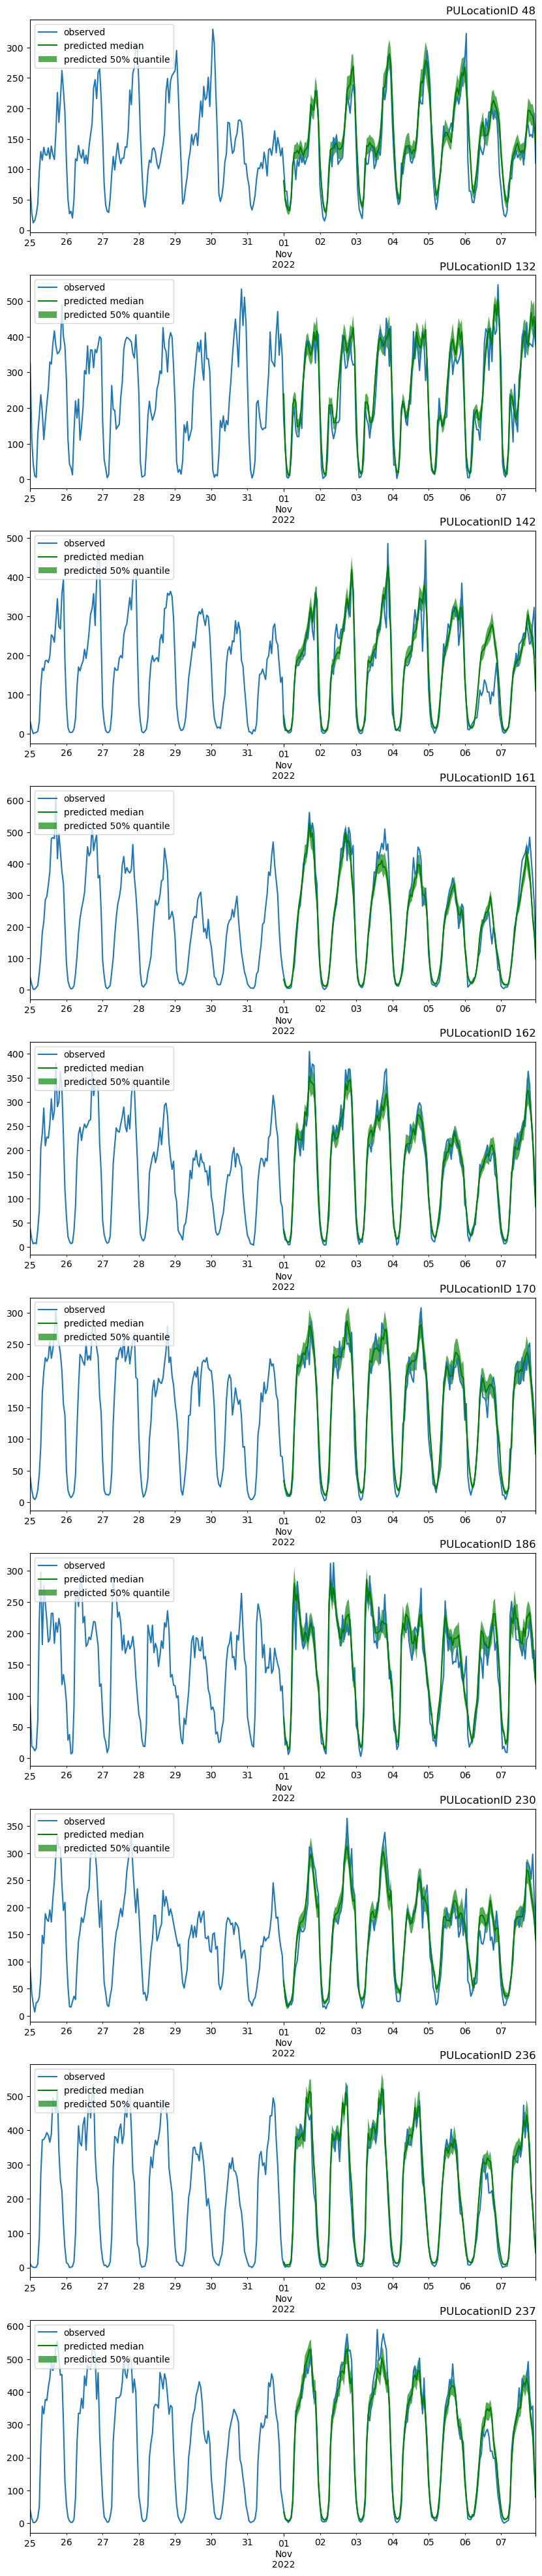

In [84]:
n_plot = 10
#N = 10
#indices = np.random.choice(np.arange(0, N), size=n_plot, replace=False)
indices = range(0, n_plot)
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
for index, ax in zip(indices, axes):
    item_id = int(forecasts[index].item_id)
    tests[index][-2 * prediction_length :].plot(ax=ax)
    plt.sca(ax)
    forecasts[index].plot(prediction_intervals=[50.0], color="green")
    plt.legend(["observed", "predicted median", "predicted 50% quantile"], loc="upper left")
    plt.title(f"PULocationID {pul_sel[item_id]}", loc='right')

In [87]:
agg_metrics

{'MSE': 1052.4276573250986,
 'abs_error': 37953.67141151428,
 'abs_target_sum': 310241.0,
 'abs_target_mean': 184.6672619047619,
 'seasonal_error': 31.60525834476452,
 'MASE': 0.7386329612580046,
 'MAPE': 0.33864601483449774,
 'sMAPE': 0.2207933540755366,
 'MSIS': 5.392903556610189,
 'QuantileLoss[0.1]': 18522.923755025862,
 'Coverage[0.1]': 0.21488095238095234,
 'QuantileLoss[0.5]': 37953.67141151428,
 'Coverage[0.5]': 0.6678571428571429,
 'QuantileLoss[0.9]': 17784.41797866821,
 'Coverage[0.9]': 0.9488095238095238,
 'RMSE': 32.44114143067563,
 'NRMSE': 0.1756734848183672,
 'ND': 0.12233609165621011,
 'wQuantileLoss[0.1]': 0.05970495116707934,
 'wQuantileLoss[0.5]': 0.12233609165621011,
 'wQuantileLoss[0.9]': 0.05732452505848102,
 'mean_absolute_QuantileLoss': 24753.671048402786,
 'mean_wQuantileLoss': 0.07978852262725682,
 'MAE_Coverage': 0.4488095238095237,
 'OWA': nan}

In [88]:
forecast_df = pd.DataFrame(index=pd.date_range(start="2022-11-01 00:00:00", periods = 24 * 7, freq="1H"))

forecast_df

""
2022-11-01 00:00:00
2022-11-01 01:00:00
2022-11-01 02:00:00
2022-11-01 03:00:00
2022-11-01 04:00:00
...
2022-11-07 19:00:00
2022-11-07 20:00:00
2022-11-07 21:00:00
2022-11-07 22:00:00


In [89]:
forecasts[0].quantile(0.5)

array([ 81.296265,  48.6089  ,  38.49788 ,  33.2329  ,  31.825277,
        53.954712, 104.551674, 126.78742 , 127.18318 , 130.94911 ,
       125.585304, 136.60875 , 128.98117 , 122.2546  , 130.81876 ,
       133.45084 , 138.39893 , 170.75198 , 206.9559  , 198.43481 ,
       197.26082 , 229.22269 , 219.43971 , 180.58186 , 114.31445 ,
        74.58709 ,  46.87326 ,  32.282413,  30.076868,  49.007454,
        93.264854, 132.02138 , 133.93134 , 134.80957 , 140.52931 ,
       142.63332 , 133.7728  , 132.88554 , 133.93324 , 140.45369 ,
       159.01529 , 191.96812 , 229.84729 , 235.7629  , 239.05879 ,
       260.588   , 269.25467 , 232.00777 , 161.03772 , 109.26305 ,
        64.771545,  46.20582 ,  38.754192,  53.75749 , 100.30795 ,
       138.85724 , 137.2204  , 143.96681 , 139.06763 , 137.85153 ,
       135.18805 , 119.947395, 129.37242 , 132.67015 , 154.11221 ,
       189.40146 , 233.84692 , 235.38896 , 255.48116 , 277.99686 ,
       289.23468 , 275.75577 , 210.97713 , 150.58139 , 101.268

In [93]:
for n in range(10):
    item_id = int(forecasts[n].item_id)
    forecast_df[pul_sel[item_id]] = forecasts[n].quantile(0.5)

In [94]:
forecast_df

,237,236,161,186,162,132,142,170,230,48
2022-11-01 00:00:00,34.809460,15.842801,33.299797,65.244164,35.747818,239.130020,46.511070,33.772171,64.304649,81.296265
2022-11-01 01:00:00,14.965312,6.592892,14.546860,32.887394,21.475422,82.840797,17.045429,22.718653,32.523022,48.608898
2022-11-01 02:00:00,9.366215,7.643106,8.799880,24.889177,10.818439,32.856083,8.333202,15.762423,18.187626,38.497879
2022-11-01 03:00:00,7.453127,7.810939,9.308111,14.136225,8.824555,12.777963,6.998076,11.138103,17.615610,33.232899
2022-11-01 04:00:00,9.080372,9.608572,11.468083,18.902397,11.425080,11.402898,8.569851,11.035522,23.387745,31.825277
...,...,...,...,...,...,...,...,...,...,...
2022-11-07 19:00:00,356.398468,316.181702,367.260437,233.207199,301.634521,421.960632,270.670654,213.271469,248.810272,196.222046
2022-11-07 20:00:00,311.366577,240.041397,305.519958,209.105698,268.455505,466.953156,256.902466,193.129211,220.614334,190.536591
2022-11-07 21:00:00,277.283783,170.297745,228.512375,188.565567,230.651398,429.760529,245.728806,160.011917,207.818039,187.414597
2022-11-07 22:00:00,169.601395,99.898926,185.266312,146.400696,143.541138,456.178314,195.671600,117.264732,181.331985,174.378387


In [95]:
gluonts_forecasts_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/gluonts_forecasts.csv"
forecast_df.to_csv(gluonts_forecasts_path_name)

**an experiment to see if a lag feature boosts performance. You can ignore below**

In [45]:
'''
add lag features
'''
ids = df_sel['PULocationID'].unique()
# may up to 9 hours history is related to the future. May be 24 hours.
df_sel['count_lag_1'] = np.NaN
for i in ids:
    df_sel.loc[df_sel['PULocationID']==i, 'count_lag_1'] \
        = df_sel[df_sel['PULocationID']==i].sort_values(by=['pickup_time'])['count'].shift(periods=1)


In [46]:
df_sel[df_sel['PULocationID']==48]

,PULocationID,count,count_lag_1
pickup_time,,,
2020-11-01 00:00:00,48,132,NaN
2020-11-01 01:00:00,48,148,132.0
2020-11-01 02:00:00,48,29,148.0
2020-11-01 03:00:00,48,19,29.0
2020-11-01 04:00:00,48,11,19.0
...,...,...,...
2022-11-30 20:00:00,48,197,179.0
2022-11-30 21:00:00,48,240,197.0
2022-11-30 22:00:00,48,261,240.0


In [47]:
# faster 0.15433716773986816 secs
import time
start = time.time()

max_end = max(df_sel.groupby("PULocationID").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in df_sel.groupby("PULocationID"):
    no = pul_sel.index(item_id)
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")
    dfs_dict[no] = gdf.reindex(new_index)
    dfs_dict[no]['PULocationID'].fillna(item_id, inplace=True)
    dfs_dict[no]['count'].fillna(0, inplace=True)
    dfs_dict[no]['count_lag_1'] = dfs_dict[no]['count'].shift(periods=1)
    dfs_dict[no]['count_lag_1'].fillna(0, inplace=True)

print(time.time() - start)
#from gluonts.dataset.pandas import PandasDataset
#ds = PandasDataset(dfs_dict, target="target")

0.04280400276184082


In [48]:
dfs_dict[0].head(20)

,PULocationID,count,count_lag_1
2020-11-01 00:00:00,237.0,21.0,0.0
2020-11-01 01:00:00,237.0,19.0,21.0
2020-11-01 02:00:00,237.0,5.0,19.0
2020-11-01 03:00:00,237.0,0.0,5.0
2020-11-01 04:00:00,237.0,2.0,0.0
2020-11-01 05:00:00,237.0,2.0,2.0
2020-11-01 06:00:00,237.0,11.0,2.0
2020-11-01 07:00:00,237.0,35.0,11.0
2020-11-01 08:00:00,237.0,31.0,35.0
2020-11-01 09:00:00,237.0,60.0,31.0


In [49]:
train_ds = PandasDataset(
    {pulid: puldf.loc[:'2022-10-31'] for pulid, puldf in dfs_dict.items()},
    feat_dynamic_real=["count_lag_1"],
    target = "count",
    freq = "1H"
)
# or testing we feed the entire dataset into make_evaluation_predictions, 
# which automatically splits the last prediction_length entries for us and returns their predictions. 
test_ds = PandasDataset(
    {pulid: puldf.loc[:'2022-11-07'] for pulid, puldf in dfs_dict.items()},
    feat_dynamic_real=["count_lag_1"],
    target = "count",
    freq = "1H"
)

In [50]:
# 1 weeks of prediction
prediction_length = 24 * 7
estimator = DeepAREstimator(
    freq="1H",
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(epochs=10),
)

In [51]:
predictor = estimator.train(train_ds)
forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor)
forecasts = list(forecast_it)
tests = list(ts_it)
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tests, forecasts, num_series=len(test_ds))

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 36.42it/s]


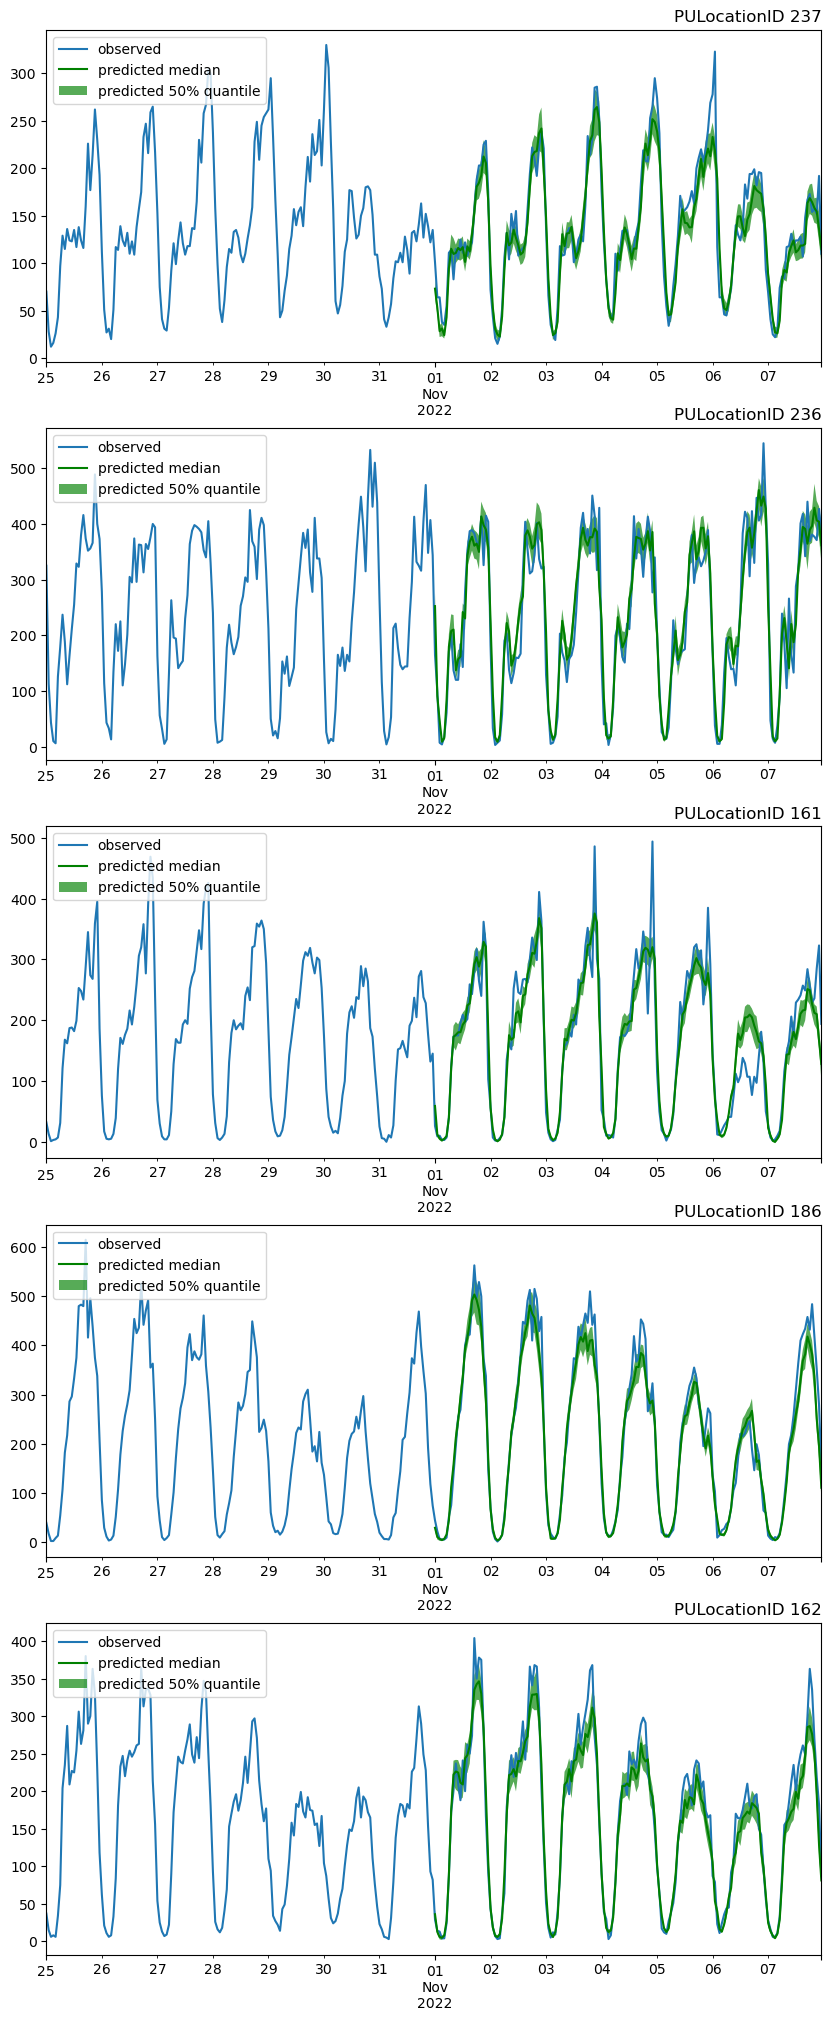

In [52]:
n_plot = 5
#N = 10
#indices = np.random.choice(np.arange(0, N), size=n_plot, replace=False)
indices = range(0, 5)
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
for index, ax in zip(indices, axes):
    tests[index][-2 * prediction_length :].plot(ax=ax)
    plt.sca(ax)
    forecasts[index].plot(prediction_intervals=[50.0], color="green")
    plt.legend(["observed", "predicted median", "predicted 50% quantile"], loc="upper left")
    plt.title(f"PULocationID {pul_sel[index]}", loc='right')

In [53]:
agg_metrics

{'MSE': 951.628396922765,
 'abs_error': 35937.370585613884,
 'abs_target_sum': 310241.0,
 'abs_target_mean': 184.6672619047619,
 'seasonal_error': 31.60525834476452,
 'MASE': 0.7021201115817057,
 'MAPE': 0.2068002236794746,
 'sMAPE': 0.18247105691295268,
 'MSIS': 4.881204969518122,
 'QuantileLoss[0.1]': 16731.154635207728,
 'Coverage[0.1]': 0.07916666666666666,
 'QuantileLoss[0.5]': 35937.370585613884,
 'Coverage[0.5]': 0.4351190476190476,
 'QuantileLoss[0.9]': 17337.553616046906,
 'Coverage[0.9]': 0.8619047619047618,
 'RMSE': 30.848474790867133,
 'NRMSE': 0.1670489640268591,
 'ND': 0.11583694800369353,
 'wQuantileLoss[0.1]': 0.053929540696451235,
 'wQuantileLoss[0.5]': 0.11583694800369353,
 'wQuantileLoss[0.9]': 0.05588414689240592,
 'mean_absolute_QuantileLoss': 23335.359612289507,
 'mean_wQuantileLoss': 0.07521687853085023,
 'MAE_Coverage': 0.3873015873015873,
 'OWA': nan}

In [54]:
'''
-----------------------------------------------------------------------------------------
'''

'\n-----------------------------------------------------------------------------------------\n'

In [55]:
'''
#slower 51.51436710357666 secs
import time
start = time.time()

max_end = df.index.max()
plids = df['PULocationID'].unique()
df_imp = pd.DataFrame()
for plid in plids:
    pl = df[df['PULocationID']==plid]
    pl = pl.reindex(pd.date_range(pl.index[0], end=max_end, freq="1H"))
    pl = pl.reset_index()
    pl.fillna(plid, inplace=True)
    pl.fillna(0, inplace=True)
    df_imp = pd.concat([df_imp, pl], ignore_index=True)

print(time.time() - start)
'''

'\n#slower 51.51436710357666 secs\nimport time\nstart = time.time()\n\nmax_end = df.index.max()\nplids = df[\'PULocationID\'].unique()\ndf_imp = pd.DataFrame()\nfor plid in plids:\n    pl = df[df[\'PULocationID\']==plid]\n    pl = pl.reindex(pd.date_range(pl.index[0], end=max_end, freq="1H"))\n    pl = pl.reset_index()\n    pl.fillna(plid, inplace=True)\n    pl.fillna(0, inplace=True)\n    df_imp = pd.concat([df_imp, pl], ignore_index=True)\n\nprint(time.time() - start)\n'